# Train Budget Allocator — UniGuard Wallet

This notebook trains the **Budget Allocator** model from scratch for UniGuard Wallet,
using **multiple Kaggle budget/survey datasets**, then fitting a **multi-output
Linear Regression** model on the full cleaned data.

## End-to-end steps in this notebook

1. **Set up paths and imports**  
   - Configure `PROJECT_ROOT` and `BACKEND_ROOT`.  
   - Import the shared training pipeline from `backend/training/` (`pipeline`, `train_models`).

2. **Select the model**  
   - Set `MODEL_NAME = "budget_allocator"` so all pipeline steps run for this model.

3. **Download all Kaggle datasets for this model**  
   - Uses `backend/training/models/budget_allocator/datasets.json` and
     `DEFAULT_DATASET_PATHS` in `backend/training/train_models.py`.  
   - Currently includes curated sources like:
     - `shrinolo/budget-allocation` (rural/urban budget splits)
     - `shriyashjagtap/indian-personal-finance-and-spending-habits` (budget + habits)
   - `pipeline.download_datasets(...)` downloads each dataset via `kagglehub` and writes
     `backend/training/data/datasets_manifest.json`.

4. **Export cleaned, merged budget-share dataset**  
   - `pipeline.export_clean(MODEL_NAME)`:
     - Reads all Kaggle budget allocation and habits files.  
     - Normalizes category names, computes per-row budget shares.  
     - Writes a single combined CSV:
       - `backend/training/models/budget_allocator/cleaned/budget_shares_clean.csv`

5. **Save a copy of the cleaned dataset next to this notebook**  
   - The `# 2b` cell copies `budget_shares_clean.csv` to:
     - `notebooks/budget_allocator_clean.csv`

6. **Inspect budget-share statistics and evaluate the rule-based allocator**  
   - Build rows via `train_models.build_budget_share_rows()`.  
   - Show shape, categories (columns), and sample rows.  
   - Run `train_models.evaluate_budget_allocator()` to compute a baseline **RMSE** on
     a random train/test split.

7. **(Optional) Visualize metrics and average shares**  
   - Plot RMSE and average budget shares per category.

8. **Train the best ML algorithm (multi-output Linear Regression) on full cleaned data**  
   - Load `notebooks/budget_allocator_clean.csv`.  
   - Use **all columns** as both inputs and outputs (auto-encoder style baseline).  
   - Fit a `MultiOutputRegressor(LinearRegression)` on the entire dataset.  
   - Compute and print final **RMSE** over all categories.  
   - Save the trained model as:
     - `notebooks/budget_allocator_linreg.pkl`

To train with **even more Kaggle budget data**, extend
`backend/training/models/budget_allocator/datasets.json` with new dataset IDs, re-run
this notebook’s download/cleaning cells, then re-run the final training cell.


## End-to-end pipeline for this model

This notebook trains the **Budget Allocator** from scratch using **multiple Kaggle datasets** and the shared Python training pipeline.

**The full sequence of steps is:**

1. **Configure Kaggle datasets** (in `backend/training/models/budget_allocator/datasets.json`).
2. **Load and display dataset list** via `pipeline.load_model_datasets(MODEL_NAME)`.
3. **Download all Kaggle datasets** with `pipeline.download_datasets(...)`.
4. **Build and export cleaned budget share data** using `pipeline.export_clean(MODEL_NAME)`.
5. **Save a copy of the cleaned CSV** next to this notebook (`notebooks/budget_allocator_clean.csv`).
6. **Build the full budget share dataset** in memory using `train_models.build_budget_share_rows()`.
7. **Compute statistics and evaluation metrics** on real data using `train_models.evaluate_budget_allocator()`.
8. **Train a final multi‑output Linear Regression model** on the full cleaned dataset and save it as `budget_allocator_linreg.pkl`.
9. **Generate graphs** for RMSE and average shares by category.

You can add more Kaggle datasets to the JSON config and re‑run all cells to retrain with more data.

In [7]:
import sys
from pathlib import Path

# Adjust this if you move the repo
PROJECT_ROOT = Path("/home/mukama/Desktop/finance 2 (Copy)").resolve()
BACKEND_ROOT = PROJECT_ROOT / "backend"

if str(BACKEND_ROOT) not in sys.path:
    sys.path.append(str(BACKEND_ROOT))

from training import pipeline, train_models

print("PROJECT_ROOT:", PROJECT_ROOT)
print("BACKEND_ROOT:", BACKEND_ROOT)
print("Artifacts dir (TS) will be:", (PROJECT_ROOT / "frontend" / "src" / "lib" / "ai" / "models" / "artifacts"))


PROJECT_ROOT: /home/mukama/Desktop/finance 2 (Copy)
BACKEND_ROOT: /home/mukama/Desktop/finance 2 (Copy)/backend
Artifacts dir (TS) will be: /home/mukama/Desktop/finance 2 (Copy)/frontend/src/lib/ai/models/artifacts


In [8]:
# This notebook is dedicated to the budget allocator model.
MODEL_NAME = "budget_allocator"
print("Current model:", MODEL_NAME)


Current model: budget_allocator


In [9]:
# 1) Download datasets for the budget allocator (Kaggle)

datasets = pipeline.load_model_datasets(MODEL_NAME)
if not datasets:
    raise SystemExit(f"No datasets configured for model '{MODEL_NAME}'. Check backend/training/models/{MODEL_NAME}/datasets.json")

print("Datasets to download:")
for d in datasets:
    print("  -", d)

manifest = pipeline.download_datasets(datasets)
print("\nDownload manifest written to:", pipeline.MANIFEST_PATH)
manifest


Datasets to download:
  - shrinolo/budget-allocation
  - shriyashjagtap/indian-personal-finance-and-spending-habits
Downloaded shrinolo/budget-allocation -> /home/mukama/.cache/kagglehub/datasets/shrinolo/budget-allocation/versions/1
Downloaded shriyashjagtap/indian-personal-finance-and-spending-habits -> /home/mukama/.cache/kagglehub/datasets/shriyashjagtap/indian-personal-finance-and-spending-habits/versions/1

Download manifest written to: /home/mukama/Desktop/finance 2 (Copy)/backend/training/data/datasets_manifest.json


{'shrinolo/budget-allocation': '/home/mukama/.cache/kagglehub/datasets/shrinolo/budget-allocation/versions/1',
 'shriyashjagtap/indian-personal-finance-and-spending-habits': '/home/mukama/.cache/kagglehub/datasets/shriyashjagtap/indian-personal-finance-and-spending-habits/versions/1'}

In [14]:
# 2) Export cleaned datasets for this model (optional but recommended)

pipeline.export_clean(MODEL_NAME)
print("Cleaned data exported under:", (pipeline.MODELS_DIR / MODEL_NAME / "cleaned"))


Cleaned data written to: /home/mukama/Desktop/finance 2 (Copy)/backend/training/models/budget_allocator/cleaned
Cleaned data exported under: /home/mukama/Desktop/finance 2 (Copy)/backend/training/models/budget_allocator/cleaned


In [15]:
# 2b) Save cleaned dataset next to this notebook

from pathlib import Path
import shutil

NOTEBOOK_DIR = PROJECT_ROOT / "notebooks"
SRC_DIR = pipeline.MODELS_DIR / MODEL_NAME / "cleaned"
SRC_FILE = SRC_DIR / "budget_shares_clean.csv"
DST_FILE = NOTEBOOK_DIR / "budget_allocator_clean.csv"

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)

if SRC_FILE.exists():
    shutil.copy(SRC_FILE, DST_FILE)
    print("Saved cleaned dataset copy to:", DST_FILE)
else:
    print("Cleaned source file not found:", SRC_FILE)
    print("Make sure you ran the 'export cleaned datasets' cell first.")

Saved cleaned dataset copy to: /home/mukama/Desktop/finance 2 (Copy)/notebooks/budget_allocator_clean.csv


In [16]:
# 3) Data statistics and evaluation on real data

import pandas as pd

# Build budget share rows exactly as the training pipeline does
rows = train_models.build_budget_share_rows()
print("Number of budget share rows:", len(rows))

if rows:
    df = pd.DataFrame(rows)
    print("DataFrame shape:", df.shape)
    print("Columns (categories):", list(df.columns)[:20])

    print("\nSample rows:")
    display(df.head())
else:
    print("No budget share data available. Check that Kaggle datasets were downloaded correctly.")

# Evaluate the budget allocator on a hold-out split of the real data
metrics = train_models.evaluate_budget_allocator()

print("\nEvaluation metrics on real data (recomputed each run):")
for key, value in metrics.items():
    print(f"  {key}: {value}")

Number of budget share rows: 22000
DataFrame shape: (22000, 12)
Columns (categories): ['Rent', 'Transport', 'Food', 'Utilities', 'Entertainment', 'Savings', 'Debt Payments', 'Insurance', 'Eating_Out', 'Health', 'Education', 'Miscellaneous']

Sample rows:


,Rent,Transport,Food,Utilities,Entertainment,Savings,Debt Payments,Insurance,Eating_Out,Health,Education,Miscellaneous
0,0.349436,0.057842,0.325123,0.131416,0.065946,0.070237,NaN,NaN,NaN,NaN,NaN,NaN
1,0.276806,0.066450,0.362444,0.140096,0.057703,0.096501,NaN,NaN,NaN,NaN,NaN,NaN
2,0.241396,0.053836,0.440954,0.158352,0.022103,0.083360,NaN,NaN,NaN,NaN,NaN,NaN
3,0.150576,0.056082,0.504866,0.140077,0.055442,0.092958,NaN,NaN,NaN,NaN,NaN,NaN
4,0.246140,0.016108,0.436368,0.096645,0.085996,0.118743,NaN,NaN,NaN,NaN,NaN,NaN



Evaluation metrics on real data (recomputed each run):
  samples: 4400
  rmse: 0.0371


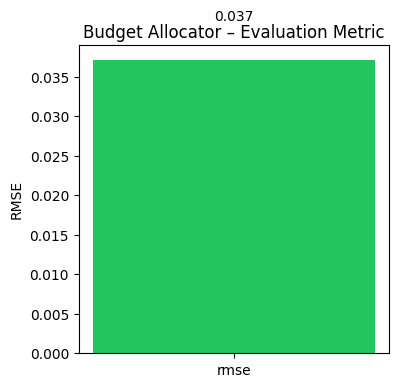

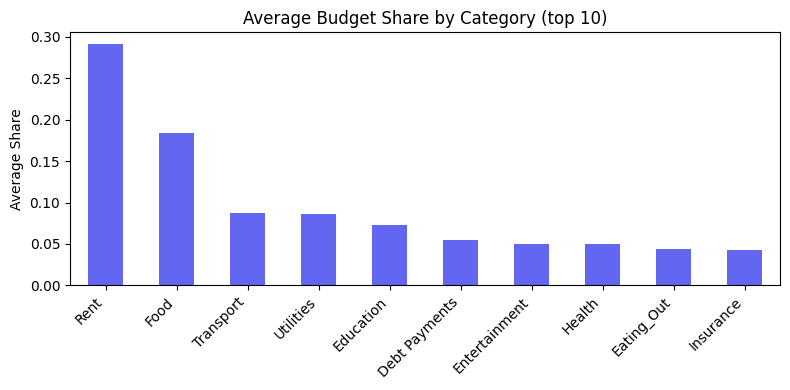

In [18]:
# 4) Visualize model performance and data (graphs)

import matplotlib.pyplot as plt

# --- Metric bar chart ---
metric_keys = ["rmse"]
metric_vals = [float(metrics.get("rmse", 0.0))]

plt.figure(figsize=(4, 4))
plt.bar(metric_keys, metric_vals, color=["#22c55e"])
plt.ylabel("RMSE")
plt.title("Budget Allocator – Evaluation Metric")
for i, v in enumerate(metric_vals):
    plt.text(i, v + 0.005, f"{v:.3f}", ha="center")
plt.show()

# --- Category-wise mean shares (top 10) ---
if "rows" in globals() and rows:
    import pandas as pd
    df = pd.DataFrame(rows).fillna(0)
    mean_shares = df.mean().sort_values(ascending=False).head(10)
    plt.figure(figsize=(8, 4))
    mean_shares.plot(kind="bar", color="#6366f1")
    plt.title("Average Budget Share by Category (top 10)")
    plt.ylabel("Average Share")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [ ]:
# 3) Train the budget allocator and write TS artifacts

# Ensure training code sees the latest dataset manifest
train_models.DATASET_PATHS = train_models.resolve_dataset_paths()

print(f"Running training for model: {MODEL_NAME}")
train_models.run_training(MODEL_NAME)

print("\nTraining complete. Artifacts should now be in:")
print(PROJECT_ROOT / "frontend" / "src" / "lib" / "ai" / "models" / "artifacts")


In [ ]:
# placeholder